# Predictive Election NN Model

Using the cleaned registration and election result data, built a neural network model for predicting outcomes of elections. Input features are:

* Partisan registration in upcoming election
* Partisan registration in prior election
* Outcome of prior election

One of the challenges with predicting election outcomes in Colorado is the variability due to about a third of the state being unaffiliated with the two major parties. The behavior of those unaffiliateds with vary by district, so we need a model that can account for that.

We have a pretty limited dataset, using the following combinations

| Inputs | Output |
|---------|----------|
|2012 reg., results, 2016 reg. | 2016 results |
|2014 reg., results, 2018 reg. | 2018 results |
|2016 reg., results, 2020 reg. | 2020 results |

with the final goal of using the 2016 reg. and results + the most current 2020 reg. to predict the 2020 results.

In [1]:
# Useful imports
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise
from tensorflow import keras

from matplotlib import pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

# needed for our loss plots
from IPython.display import clear_output

%matplotlib inline

res_dir = '../data/results/cleaned'
reg_dir = '../data/registration/cleaned'

build_models = False

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()      
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.loglog(self.x, self.losses, label="loss")
        plt.loglog(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.ylabel('error')
        plt.xlabel('epoch')
        plt.show();
        
plot_losses = PlotLosses()

## Data Preparation

Need to arrange the cleaned CSV files into the inputs and outputs with appropriate groupings.

Senate elections are every four years, so prior results from 2012 will be paired with registration in 2016 to predict the 2016 outcome. Similarly with 2014 and 2018.

First, define some helper functions that will pre-process the data from the cleaned registration and results files

In [3]:
def get_registration(year):
    """Given an input year, snag the registration data for that year and collapse the affiliation of active
    voters into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""
    
    # read in the data
    reg_df = pd.read_csv(reg_dir+'/senate_{}.csv'.format(year))
    
    # filter out where the county value is empty, which is a "total" row
    reg_df = reg_df[reg_df['COUNTY'].notnull()]
    
    # isolate only active voters
    active_cols = [col for col in reg_df.columns if '-ACTIVE' in col]
    
    # find third-party/unaffiliated voter data
    other_cols = [col for col in active_cols if 'DEM' not in col and 'REP' not in col]
    
    # combine all unaffiliateds into one column
    reg_df['OTHER-ACTIVE'] = reg_df[other_cols].sum(axis=1)
    
    # combine the district and county labels into one
    reg_df['DIST_COUNTY'] = reg_df['DISTRICT'].astype(str) +'-'+ reg_df['COUNTY'].astype(str)

    # pick off only the interesting data
    relabel_dict = {
        'REP-ACTIVE' : 'REP',
        'DEM-ACTIVE' : 'DEM',
        'OTHER-ACTIVE' : 'OTHER'
    }
    new_df = reg_df[['DIST_COUNTY', 'REP-ACTIVE', 'DEM-ACTIVE', 'OTHER-ACTIVE']].rename(columns=relabel_dict)
    
    return new_df
    
def get_results(year):
    """Given an input year, snag the results data for that year and collapse the affiliation of active
    candidates into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""

    # read in the results file
    df = pd.read_csv(res_dir+'/senate_{}.csv'.format(year))
    
    # create a DIST-COUNTY label
    df['DIST_COUNTY'] = df['DISTRICT'].astype(str) + '-' + df['COUNTY'].astype(str)
    
    # isolate third party candidates
    parties = ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY']
    df['PARTY'][~df['PARTY'].isin(parties)] = 'OTHER'
    df['PARTY'][df['PARTY'] == 'REPUBLICAN PARTY'] = 'REP'
    df['PARTY'][df['PARTY'] == 'DEMOCRATIC PARTY'] = 'DEM'

    # sum over precincts, if precincts exist
    agg_cols = {'YES VOTES' : 'sum'}
    df = df.groupby([df['DIST_COUNTY'], df['PARTY']], as_index=False).aggregate(agg_cols)
    
    # Make party votes into columns for each DIST_COUNTY
    df = df.pivot(index='DIST_COUNTY', columns='PARTY', values='YES VOTES').fillna(0)
    df.reset_index(level=0, inplace=True)

    return df

At this point, it is helpful to combine the all the relevant input and output data for each dist-county into a single input and output dataframe.

In [4]:
# Will store the district-county data using the standard key format 
# 'SD [NUMBER]-[COUNTY]' for the Year of the Predicted Results
year_pairs = [['2012', '2016'], ['2014', '2018']]

X_set = np.array([], dtype=np.float64).reshape(0,9)
Y_set = np.array([], dtype=np.float64).reshape(0,3)

dfs = []

for pair in year_pairs:
    
    # The output variables
    current_result = get_results(pair[1])
    elections = current_result.DIST_COUNTY.unique()
    current_result = current_result.rename(
        columns={'DEM' : 'DEM_curr_votes',
                 'REP' : 'REP_curr_votes',
                 'OTHER' : 'OTHER_curr_votes'}
    )
        
    # The input variables
    
    # current registration
    current_reg = get_registration(pair[1])
    current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]
    
    current_reg = current_reg.rename(
        columns={'DEM' : 'DEM_curr_reg',
                 'REP' : 'REP_curr_reg',
                 'OTHER' : 'OTHER_curr_reg'}
    )
    
    # prior election registration
    past_reg = get_registration(pair[0])
    past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]
    
    past_reg = past_reg.rename(
        columns={'DEM' : 'DEM_past_reg',
                 'REP' : 'REP_past_reg',
                 'OTHER' : 'OTHER_past_reg'}
    )
    
    # prior election result registration
    past_result = get_results(pair[0])
    past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]
    
    past_result = past_result.rename(
        columns={'DEM' : 'DEM_past_votes',
                 'REP' : 'REP_past_votes',
                 'OTHER' : 'OTHER_past_votes'}
    )
    
    # compute fractional current registration
    tot_regs = current_reg.sum(axis=1).values
    current_reg.DEM_curr_reg  = current_reg.DEM_curr_reg.values/tot_regs
    current_reg.REP_curr_reg  = current_reg.REP_curr_reg.values/tot_regs
    current_reg.OTHER_curr_reg = current_reg.OTHER_curr_reg.values/tot_regs
    
    # compute fractional past registration
    tot_regs = past_reg.sum(axis=1).values
    past_reg.DEM_past_reg  = past_reg.DEM_past_reg.values/tot_regs
    past_reg.REP_past_reg  = past_reg.REP_past_reg.values/tot_regs
    past_reg.OTHER_past_reg = past_reg.OTHER_past_reg.values/tot_regs
    
    # compute fractional past votes
    tot_votes = past_result.sum(axis=1).values
    past_result.DEM_past_votes = past_result.DEM_past_votes.values/tot_votes
    past_result.REP_past_votes = past_result.REP_past_votes.values/tot_votes
    past_result.OTHER_past_votes = past_result.OTHER_past_votes.values/tot_votes

    
    X_df = current_reg
    X_df = pd.merge(X_df, past_reg, on='DIST_COUNTY')
    X_df = pd.merge(X_df, past_result, on='DIST_COUNTY')
    
    # Now for the outputs
    # compute current fractional votes
    tot_votes = current_result.sum(axis=1).values
    current_result.DEM_curr_votes = current_result.DEM_curr_votes.values/tot_votes
    current_result.REP_curr_votes = current_result.REP_curr_votes.values/tot_votes
    current_result.OTHER_curr_votes = current_result.OTHER_curr_votes.values/tot_votes

    X_df = pd.merge(X_df, current_result, on='DIST_COUNTY')
    
    dfs.append(X_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
result = pd.concat(dfs)
X_cols = ['REP_curr_reg', 'DEM_curr_reg', 'OTHER_curr_reg',
          'REP_past_reg', 'DEM_past_reg', 'OTHER_past_reg',
          'REP_past_votes', 'DEM_past_votes', 'OTHER_past_votes']
Y_cols = ['DEM_curr_votes', 'OTHER_curr_votes', 'REP_curr_votes']

print(result[Y_cols])

X_set = result[X_cols].values
Y_set = result[Y_cols].values

    DEM_curr_votes  OTHER_curr_votes  REP_curr_votes
0         0.306071          0.000000        0.693929
1         0.452293          0.000000        0.547707
2         0.426006          0.000000        0.573994
3         0.242875          0.000000        0.757125
4         0.171046          0.000000        0.828954
..             ...               ...             ...
42        0.581584          0.000000        0.418416
43        0.523152          0.078830        0.398018
44        0.415604          0.056568        0.527828
45        0.719908          0.046538        0.233554
46        0.831349          0.000000        0.168651

[89 rows x 3 columns]


## Model Training

### Split the Data

Split into a train-test split to validate the data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
print(np.shape(X_set))
X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=.2)
print(np.shape(X_test))

(89, 9)
(17, 9)


### Train an ensemble of models

Because of the small number of data points, uncertainty quantification is important. So, build an ensemble of models from different training data, and then make the predictions using the average/spread of each model.

For a 20% train-test split, there are $\binom{89}{71} \approx 3 \times 10^{18}$ possible combinations. So, we aren't too worried about repeats.

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: ./model/senate/model_0/assets
INFO:tensorflow:Assets written to: ./model/senate/model_1/assets
INFO:tensorflow:Assets written to: ./model/senate/model_2/assets
INFO:tensorflow:Assets written to: ./model/senate/model_3/assets
INFO:tensorflow:Assets written to: ./model/senate/model_4/assets
INFO:tensorflow:Assets written to: ./model/senate/model_5/assets
INFO:tensorflow:Assets written to: ./model/senate/model_6/assets
INFO:tensorflow:Assets written to: ./model/senate/model_7/assets
INFO:tensorflow:Assets written to: ./model/senate/model_8/assets
INFO:tensorflow:Assets written to: ./model/senate/model_9/assets
INFO:tensorflow:Assets written to: ./model/senate/model_10/assets
INFO:tensorflow:Assets written to: ./model/senate/model_11/assets
INFO:tensorflow:Assets written to: ./model/senate/model_12/assets
INFO:tensorflow:Assets written to: ./model/senate/model_13/assets
INFO:tensorflow:Assets written to: ./model/senate/model_14/assets
INFO:tensorflow:Asse

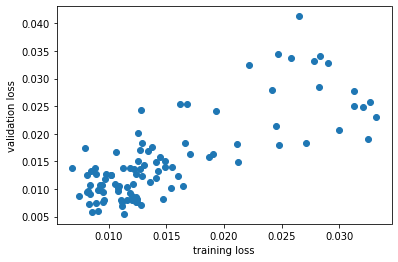

In [8]:
if build_models:
    n_models = 100
    train_size = .3
    models_dict = {}

    losses = []
    vals = []

    for model_num in tqdm(range(n_models)):

        X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=train_size)
        model = Sequential()

        model.add(Dense(2, input_dim=9, activation='tanh'))
        model.add(GaussianNoise(stddev=.1))
        model.add(Dense(3, activation='sigmoid'))

        model.compile(loss='mean_squared_error', optimizer='adam')

        hist = model.fit(x=X_train, y=Y_train, 
                        validation_data= (X_test, Y_test),
                        batch_size = 20,
                        shuffle = True,
                        epochs = 500,
                        verbose = False)
        model.save('./model/senate/model_{}'.format(model_num))
        losses.append(hist.history['loss'][-1])
        vals.append(hist.history['val_loss'][-1])
    
    plt.scatter(losses, vals)
    plt.xlabel('training loss')
    plt.ylabel('validation loss')
pass;

## 2020 Predictions

In [9]:
pair = ['2016', '2020']

# The input variables

# prior election result registration
past_result = get_results(pair[0])
elections = past_result['DIST_COUNTY'].unique()
past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]

past_result = past_result.rename(
    columns={'DEM' : 'DEM_past_votes',
             'REP' : 'REP_past_votes',
             'OTHER' : 'OTHER_past_votes'}
)

# current registration
current_reg = get_registration(pair[1])
current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]

current_reg = current_reg.rename(
    columns={'DEM' : 'DEM_curr_reg',
             'REP' : 'REP_curr_reg',
             'OTHER' : 'OTHER_curr_reg'}
)

# prior election registration
past_reg = get_registration(pair[0])
past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]

past_reg = past_reg.rename(
    columns={'DEM' : 'DEM_past_reg',
             'REP' : 'REP_past_reg',
             'OTHER' : 'OTHER_past_reg'}
)

# compute fractional current registration
tot_regs = current_reg.sum(axis=1).values
current_reg.DEM_curr_reg  = current_reg.DEM_curr_reg.values/tot_regs
current_reg.REP_curr_reg  = current_reg.REP_curr_reg.values/tot_regs
current_reg.OTHER_curr_reg = current_reg.OTHER_curr_reg.values/tot_regs

# compute fractional past registration
tot_regs = past_reg.sum(axis=1).values
past_reg.DEM_past_reg  = past_reg.DEM_past_reg.values/tot_regs
past_reg.REP_past_reg  = past_reg.REP_past_reg.values/tot_regs
past_reg.OTHER_past_reg = past_reg.OTHER_past_reg.values/tot_regs

# compute fractional past votes
tot_votes = past_result.sum(axis=1).values
past_result.DEM_past_votes = past_result.DEM_past_votes.values/tot_votes
past_result.REP_past_votes = past_result.REP_past_votes.values/tot_votes
past_result.OTHER_past_votes = past_result.OTHER_past_votes.values/tot_votes


X_df = current_reg
X_df = pd.merge(X_df, past_reg, on='DIST_COUNTY')
X_df = pd.merge(X_df, past_result, on='DIST_COUNTY')

X_pred = X_df[X_cols].values

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iterate over all models, get the predicted vote totals by district-county for each model, and store. We will eventually compute total and spread of votes in each district

In [10]:
import glob

models = glob.glob('./model/senate/*')

current_reg = get_registration(pair[1])
current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]
tot_regs = current_reg.sum(axis=1).values
tot_regs = np.reshape(tot_regs, (len(tot_regs),1))

preds_array = []

for model in tqdm(models):
    this_model = keras.models.load_model(model)
    preds = this_model.predict(X_pred)
    preds_array.append(preds*tot_regs)
    
pass;

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
mean_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
                              'DEM' : np.mean(preds_array, axis=0)[:,0],
                              'REP' : np.mean(preds_array, axis=0)[:,2],
                              'OTHER' : np.mean(preds_array, axis=0)[:,1]})

print(mean_df)

std_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
                              'DEM' : np.std(preds_array, axis=0)[:,0],
                              'REP' : np.std(preds_array, axis=0)[:,2],
                              'OTHER' : np.std(preds_array, axis=0)[:,1]})

print(std_df)

         DIST_COUNTY           DEM           REP         OTHER
0       SD 4-DOUGLAS  49462.843394  76045.862747   7799.295844
1      SD 8-GARFIELD  16801.750731  16311.740799   2247.951287
2         SD 8-GRAND   4792.503625   5777.756424    673.076728
3       SD 8-JACKSON    288.249644    665.641301     70.302670
4        SD 8-MOFFAT   2543.845333   5231.433058    525.872677
5    SD 8-RIO BLANCO   1155.102254   2809.996486    305.699874
6         SD 8-ROUTT   9549.586647   7745.704760   1293.261392
7        SD 8-SUMMIT  11507.425207   7909.504945   1632.852784
8      SD 10-EL PASO  39995.652206  54317.529651   5857.536104
9      SD 12-EL PASO  31484.500522  56217.196209   5527.643836
10     SD 14-LARIMER  60694.665917  42468.036987   8607.280137
11     SD 17-BOULDER  68640.991981  35363.807760  12143.633123
12     SD 18-BOULDER  65205.381739  33608.625563  11133.136777
13   SD 19-JEFFERSON  53575.562135  47300.210829   7180.111159
14       SD 21-ADAMS  52575.994208  26974.683484   9302

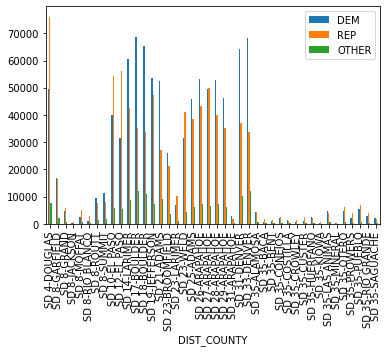

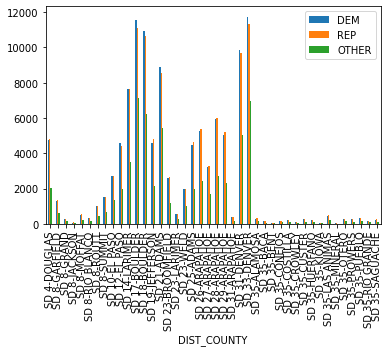

In [12]:
mean_df.plot.bar(x='DIST_COUNTY')
std_df.plot.bar(x='DIST_COUNTY')
pass;

In [13]:
mean_df['DISTRICT'] = mean_df['DIST_COUNTY'].str.split('-').str[0]
std_df['DISTRICT'] = std_df['DIST_COUNTY'].str.split('-').str[0]

mean_df['COUNTY'] = mean_df['DIST_COUNTY'].str.split('-').str[1]
std_df['COUNTY'] = std_df['DIST_COUNTY'].str.split('-').str[1]

print(mean_df)
print(std_df)

         DIST_COUNTY           DEM           REP         OTHER DISTRICT  \
0       SD 4-DOUGLAS  49462.843394  76045.862747   7799.295844     SD 4   
1      SD 8-GARFIELD  16801.750731  16311.740799   2247.951287     SD 8   
2         SD 8-GRAND   4792.503625   5777.756424    673.076728     SD 8   
3       SD 8-JACKSON    288.249644    665.641301     70.302670     SD 8   
4        SD 8-MOFFAT   2543.845333   5231.433058    525.872677     SD 8   
5    SD 8-RIO BLANCO   1155.102254   2809.996486    305.699874     SD 8   
6         SD 8-ROUTT   9549.586647   7745.704760   1293.261392     SD 8   
7        SD 8-SUMMIT  11507.425207   7909.504945   1632.852784     SD 8   
8      SD 10-EL PASO  39995.652206  54317.529651   5857.536104    SD 10   
9      SD 12-EL PASO  31484.500522  56217.196209   5527.643836    SD 12   
10     SD 14-LARIMER  60694.665917  42468.036987   8607.280137    SD 14   
11     SD 17-BOULDER  68640.991981  35363.807760  12143.633123    SD 17   
12     SD 18-BOULDER  652

### Election Predictions

Here are the total vote predictions for each district. We start with a bar chart and STD range of predictions. We will also look at the individual predictions and win percentages.

In [14]:
import matplotlib as mpl

# Use the Gill Sans font
import matplotlib.pylab as pylab

import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {
         'font.size': 14,
         'font.style': 'italic',
         'legend.fontsize': 14,
         'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

make_bars = False

if make_bars:
    width = .25

    for district in mean_df.DISTRICT.unique():
        fig, ax = plt.subplots()

        ax.set_title('District {} Predictions'.format(district));

        counties = mean_df[mean_df.DISTRICT == district].COUNTY.values

        dem_votes   = mean_df[mean_df.DISTRICT == district].DEM.values
        rep_votes   = mean_df[mean_df.DISTRICT == district].REP.values
        other_votes = mean_df[mean_df.DISTRICT == district].OTHER.values

        dem_std   = std_df[mean_df.DISTRICT == district].DEM.values
        rep_std   = std_df[mean_df.DISTRICT == district].REP.values
        other_std = std_df[mean_df.DISTRICT == district].OTHER.values

        counties = np.append(counties, 'TOTAL')

        dem_votes = np.append(dem_votes, np.sum(dem_votes))
        dem_std = np.append(dem_std, np.sum(dem_std))

        rep_votes = np.append(rep_votes, np.sum(rep_votes))
        rep_std = np.append(rep_std, np.sum(rep_std))

        other_votes = np.append(other_votes, np.sum(other_votes))
        other_std = np.append(other_std, np.sum(other_std))


        x = np.arange(len(counties))

        ax.bar(x - width, dem_votes, width, label=counties, yerr=2.*dem_std, color='tab:blue', alpha=0.5);
        ax.bar(x, rep_votes, width, label=counties, yerr = 2.*rep_std, color='tab:red', alpha=0.5);
        ax.bar(x+width, other_votes, width, label=counties, yerr = 2.*other_std, color='tab:green', alpha=0.5);

        ax.set_xticks(x)
        for tick in ax.get_xticklabels():
            tick.set_rotation(85)
        ax.set_xticklabels(counties)
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

        ax.annotate(format(int(dem_votes[-1]), ','),
                xy=(x[-1]-width, dem_votes[-1]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom');

        ax.annotate(format(int(rep_votes[-1]), ','),
                xy=(x[-1], rep_votes[-1]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom');

        ax.annotate(format(int(other_votes[-1]), ','),
                xy=(x[-1]+width, other_votes[-1]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom');


        fig.tight_layout()

        fig.savefig('../figs/forecasts/senate/{}_projection.png'.format(district))

    pass;

### Spread in Projections

Now we want to look at each model's predictions for each district, to figure out whether things are clustered, driven by outliers, etc. Key questions here are what percentage of models predict a Dem versus Rep win?

First, some data cleaning. Pandas doesn't like multidimensional arrays, so I'm using a dictionary instead.

In [15]:
print(np.shape(preds_array))
preds_array = np.array(preds_array)

preds_dict = {}

dem_votes = preds_array[:,:,0].T
rep_votes = preds_array[:,:,2].T
oth_votes = preds_array[:,:,1].T

dist_county = current_reg.DIST_COUNTY.values

for idx in range(len(dist_county)):
    preds_dict[dist_county[idx]] = preds_array[:,idx,:]

print(preds_dict.keys())


#dems_df = pd.DataFrame(data = {'DIST_COUNTY' : current_reg.DIST_COUNTY.values,
#                              'votes' : [dem_votes]})

(100, 42, 3)
dict_keys(['SD 4-DOUGLAS', 'SD 8-GARFIELD', 'SD 8-GRAND', 'SD 8-JACKSON', 'SD 8-MOFFAT', 'SD 8-RIO BLANCO', 'SD 8-ROUTT', 'SD 8-SUMMIT', 'SD 10-EL PASO', 'SD 12-EL PASO', 'SD 14-LARIMER', 'SD 17-BOULDER', 'SD 18-BOULDER', 'SD 19-JEFFERSON', 'SD 21-ADAMS', 'SD 23-BROOMFIELD', 'SD 23-LARIMER', 'SD 23-WELD', 'SD 25-ADAMS', 'SD 26-ARAPAHOE', 'SD 27-ARAPAHOE', 'SD 28-ARAPAHOE', 'SD 29-ARAPAHOE', 'SD 31-ARAPAHOE', 'SD 31-DENVER', 'SD 33-DENVER', 'SD 35-ALAMOSA', 'SD 35-BACA', 'SD 35-BENT', 'SD 35-CONEJOS', 'SD 35-COSTILLA', 'SD 35-CROWLEY', 'SD 35-CUSTER', 'SD 35-HUERFANO', 'SD 35-KIOWA', 'SD 35-LAS ANIMAS', 'SD 35-MINERAL', 'SD 35-OTERO', 'SD 35-PROWERS', 'SD 35-PUEBLO', 'SD 35-RIO GRANDE', 'SD 35-SAGUACHE'])


In [16]:
dists = mean_df.DISTRICT.unique()

dist_tots = {}

for dist in dists:
    tot_votes = 0
    for key in preds_dict.keys():
        if dist == key.split('-')[0]:
            tot_votes += preds_dict[key]
    
    dist_tots[dist] = tot_votes
    

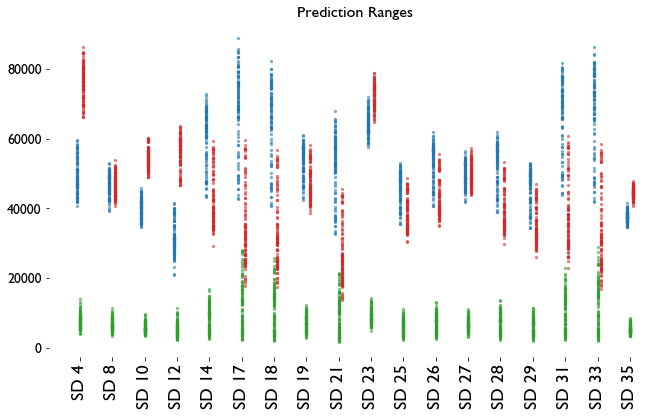

In [17]:
fig, ax = plt.subplots()
for idx, dist in enumerate(dists):
    
    ax.scatter([2*idx-.2]*np.shape(dist_tots[dist])[0], dist_tots[dist][:,0], c='tab:blue', alpha=0.5, s=5)
    ax.scatter([2*idx]*np.shape(dist_tots[dist])[0], dist_tots[dist][:,1],  c='tab:green', alpha=0.5, s=5)
    ax.scatter([2*idx+.2]*np.shape(dist_tots[dist])[0], dist_tots[dist][:,2],  c='tab:red', alpha=0.5, s=5)
    
ax.set_xticks(np.linspace(0,2*len(dists)-2, len(dists)))
ax.set_xticklabels(dists, rotation='vertical', fontsize=18)
ax.set_title('Prediction Ranges')
fig.tight_layout()
fig.savefig('senate_full_predictions.png')
pass;

In [18]:
data_to_plot_d = []
data_to_plot_r = []
data_to_plot_i = []

positions = []
quantiles = []

for idx, dist in enumerate(dists):
    
    positions.append(idx)
    data_to_plot_d.append(dist_tots[dist][:,0]/np.sum(dist_tots[dist],axis=1))
    data_to_plot_r.append(dist_tots[dist][:,2]/np.sum(dist_tots[dist],axis=1))
    data_to_plot_i.append(dist_tots[dist][:,1]/np.sum(dist_tots[dist],axis=1))
    quantiles.append([.25, .75])

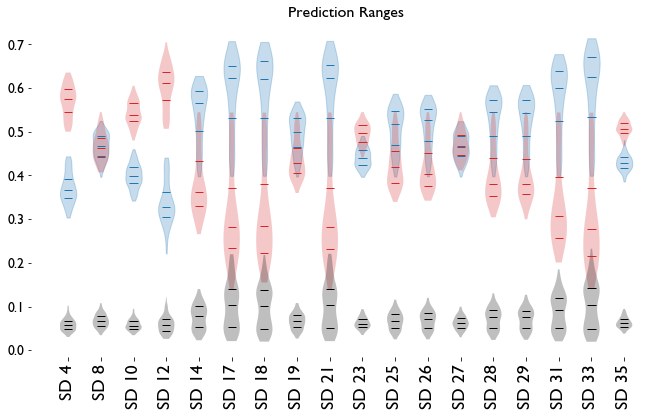

In [19]:
fig, ax = plt.subplots()

parts_d = ax.violinplot(dataset=data_to_plot_d, positions=positions, 
                        showmedians=True, showextrema=False, quantiles=quantiles)
parts_r = ax.violinplot(dataset=data_to_plot_r, positions=positions, 
                        showmedians=True, showextrema=False, quantiles=quantiles)
parts_i = ax.violinplot(dataset=data_to_plot_i, positions=positions, 
                        showmedians=True, showextrema=False, quantiles=quantiles)

for pc in parts_d['bodies']:
    pc.set_color('tab:blue')
    pc.set_alpha(.25)
    for partname in ('cquantiles','cmedians'):
        vp = parts_d[partname]
        vp.set_edgecolor('tab:blue')
        vp.set_linewidth(1)

for pc in parts_r['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_alpha(.25)
    for partname in ('cquantiles','cmedians'):
        vp = parts_r[partname]
        vp.set_edgecolor('tab:red')
        vp.set_linewidth(1)
    
for pc in parts_i['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.25)
    for partname in ('cquantiles','cmedians'):
        vp = parts_i[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

ax.set_xticks(np.linspace(0,len(dists)-1, len(dists)))
ax.set_xticklabels(dists, rotation='vertical', fontsize=18)
ax.set_title('Prediction Ranges')
fig.tight_layout()
fig.savefig('../figs/forecasts/senate_full_predictions.png')
pass;